In [1]:
!pip install roboflow

In [2]:
!pip install easyocr

  Using cached easyocr-1.7.1-py3-none-any.whl (2.9 MB)
  Using cached python_bidi-0.4.2-py2.py3-none-any.whl (30 kB)
  Using cached pyclipper-1.3.0.post5-cp310-cp310-manylinux_2_12_x86_64.manylinux2010_x86_64.whl (908 kB)
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 307.2/307.2 kB 2.5 MB/s eta 0:00:00
  Using cached nvidia_cuda_nvrtc_cu12-12.1.105-py3-none-manylinux1_x86_64.whl (23.7 MB)
  Using cached nvidia_cuda_runtime_cu12-12.1.105-py3-none-manylinux1_x86_64.whl (823 kB)
  Using cached nvidia_cuda_cupti_cu12-12.1.105-py3-none-manylinux1_x86_64.whl (14.1 MB)
  Using cached nvidia_cudnn_cu12-8.9.2.26-py3-none-manylinux1_x86_64.whl (731.7 MB)
  Using cached nvidia_cublas_cu12-12.1.3.1-py3-none-manylinux1_x86_64.whl (410.6 MB)
  Using cached nvidia_cufft_cu12-11.0.2.54-py3-none-manylinux1_x86_64.whl (121.6 MB)
  Using cached nvidia_curand_cu12-10.3.2.106-py3-none-manylinux1_x86_64.whl (56.5 MB)
  Using cached nvidia_cusolver_cu12-11.4.5.107-py3-none-manylinux1_x86_64.whl (124.2 MB)
  

In [3]:
!pip install pytesseract

In [4]:
import easyocr
import cv2
import pytesseract
import random
import tensorflow as tf
import os
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.image as mpimg
import re
from sklearn.preprocessing import LabelEncoder
from sklearn.model_selection import train_test_split
from tensorflow.keras.preprocessing.image import img_to_array, load_img
from tensorflow.keras.utils import to_categorical
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Conv2D, MaxPooling2D, Flatten, Dense
from tensorflow.keras.optimizers import Adam
from sklearn.metrics import classification_report
from pytesseract import Output
from PIL import Image

In [5]:
!apt-get install tesseract-ocr

Reading package lists... Done
Building dependency tree... Done
Reading state information... Done
The following additional packages will be installed:
  tesseract-ocr-eng tesseract-ocr-osd
The following NEW packages will be installed:
  tesseract-ocr tesseract-ocr-eng tesseract-ocr-osd
0 upgraded, 3 newly installed, 0 to remove and 45 not upgraded.
Need to get 4,816 kB of archives.
After this operation, 15.6 MB of additional disk space will be used.
Get:1 http://archive.ubuntu.com/ubuntu jammy/universe amd64 tesseract-ocr-eng all 1:4.00~git30-7274cfa-1.1 [1,591 kB]
Get:2 http://archive.ubuntu.com/ubuntu jammy/universe amd64 tesseract-ocr-osd all 1:4.00~git30-7274cfa-1.1 [2,990 kB]
Get:3 http://archive.ubuntu.com/ubuntu jammy/universe amd64 tesseract-ocr amd64 4.1.1-2.1build1 [236 kB]
Fetched 4,816 kB in 1s (9,479 kB/s)
Selecting previously unselected package tesseract-ocr-eng.
(Reading database ... 121913 files and directories currently installed.)
Preparing to unpack .../tesseract-ocr-

In [6]:
!tesseract --version

tesseract 4.1.1
 leptonica-1.82.0
  libgif 5.1.9 : libjpeg 8d (libjpeg-turbo 2.1.1) : libpng 1.6.37 : libtiff 4.3.0 : zlib 1.2.11 : libwebp 1.2.2 : libopenjp2 2.4.0
 Found AVX2
 Found AVX
 Found FMA
 Found SSE
 Found libarchive 3.6.0 zlib/1.2.11 liblzma/5.2.5 bz2lib/1.0.8 liblz4/1.9.3 libzstd/1.4.8


In [7]:
import os
os.environ['PATH'] += ":/usr/bin/tesseract"

In [8]:
from roboflow import Roboflow
rf = Roboflow(api_key="f77FoHccQ1RtNOK1tFRo")
project = rf.workspace("jakob-awn1e").project("receipt-or-invoice")
version = project.version(2)
dataset = version.download("folder")

loading Roboflow workspace...
loading Roboflow project...



Extracting Dataset Version Zip to Receipt-or-Invoice-2 in folder:: 100%|██████████| 4325/4325 [00:01<00:00, 2290.81it/s]


In [9]:
# Preprocessing
def preprocess_images(image_path):
    image = load_img(image_path, target_size=(224, 224))
    image = img_to_array(image) / 255.0
    return image

In [10]:
def label_data(data_path):
    images = []
    labels = []
    for root, dirs, files in os.walk(data_path):
        for file in files:
            if file.endswith('.jpg') or file.endswith('.png'):  # Ensure processing only image files
                file_path = os.path.join(root, file)
                label = os.path.basename(os.path.dirname(file_path))  # Correct label extraction
                image = preprocess_images(file_path)
                images.append(image)
                labels.append(label)
    return np.array(images), np.array(labels)

In [11]:
# Load dataset
train_path = "/content/Receipt-or-Invoice-2/train"
val_path = "/content/Receipt-or-Invoice-2/valid"
test_path = "/content/Receipt-or-Invoice-2/test"

In [12]:
X_train, y_train = label_data(train_path)
X_val, y_val = label_data(val_path)
X_test, y_test = label_data(test_path)

In [13]:
import numpy as np
# Combining labels from all three datasets
all_labels = np.concatenate((y_train, y_val, y_test))

# Encode labels
label_encoder = LabelEncoder()
label_encoder.fit(all_labels)

# Re-encode labels for each dataset
y_train = label_encoder.transform(y_train)
y_val = label_encoder.transform(y_val)
y_test = label_encoder.transform(y_test)

In [14]:
# Build CNN model
model = Sequential([
    Conv2D(32, (3, 3), activation='relu', input_shape=(224, 224, 3)),
    MaxPooling2D((2, 2)),
    Conv2D(64, (3, 3), activation='relu'),
    MaxPooling2D((2, 2)),
    Flatten(),
    Dense(64, activation='relu'),
    Dense(len(label_encoder.classes_), activation='softmax')
])

# Compile the model
model.compile(optimizer=Adam(), loss='sparse_categorical_crossentropy', metrics=['accuracy'])

In [15]:
# Train the model
model.fit(X_train, y_train, validation_data=(X_val, y_val), epochs=20, batch_size=32)

# Evaluate the model
_, test_acc = model.evaluate(X_test, y_test)
print("Test Accuracy:", test_acc)

Epoch 1/20
118/118 [==============================] - 13s 64ms/step - loss: 0.7003 - accuracy: 0.8227 - val_loss: 0.8906 - val_accuracy: 0.5750
Epoch 2/20
118/118 [==============================] - 5s 42ms/step - loss: 0.2106 - accuracy: 0.9202 - val_loss: 0.6477 - val_accuracy: 0.6611
Epoch 3/20
118/118 [==============================] - 5s 43ms/step - loss: 0.1278 - accuracy: 0.9542 - val_loss: 0.6721 - val_accuracy: 0.6639
Epoch 4/20
118/118 [==============================] - 5s 44ms/step - loss: 0.1193 - accuracy: 0.9555 - val_loss: 0.4470 - val_accuracy: 0.7861
Epoch 5/20
118/118 [==============================] - 5s 42ms/step - loss: 0.0821 - accuracy: 0.9663 - val_loss: 0.4524 - val_accuracy: 0.7972
Epoch 6/20
118/118 [==============================] - 5s 44ms/step - loss: 0.0502 - accuracy: 0.9828 - val_loss: 0.5998 - val_accuracy: 0.8250
Epoch 7/20
118/118 [==============================] - 5s 43ms/step - loss: 0.0317 - accuracy: 0.9886 - val_loss: 0.4213 - val_accuracy: 0.825

In [16]:
# Perform text recognition using OCR
def perform_ocr(image_path):
    reader = easyocr.Reader(['en'])
    result = reader.readtext(image_path)
    return result

In [17]:
# Perform text recognition using OCR with pytesseract
def perform_ocr_pytesseract(image_path):
    img = Image.open(image_path)
    text = pytesseract.image_to_string(img, lang='eng')
    return text

In [18]:
# Integrate everything
def integrate_ocr_with_model(image_path):
    # Predict class using the CNN model
    image = preprocess_images(image_path)
    prediction = np.argmax(model.predict(np.array([image])))

    # Perform OCR on the image using easyocr
    ocr_result_easyocr = perform_ocr(image_path)

    # Perform OCR on the image using pytesseract
    ocr_result_pytesseract = perform_ocr_pytesseract(image_path)

    return label_encoder.classes_[prediction], ocr_result_easyocr, ocr_result_pytesseract

In [19]:
def select_random_image(directory):
    all_files = []
    for root, dirs, files in os.walk(directory):
        for file in files:
            if file.endswith('.jpg') or file.endswith('.png'):
                all_files.append(os.path.join(root, file))
    random_image = random.choice(all_files)
    return random_image

1/1 [==============================] - 0s 246ms/step


Progress: |██████████████████████████████████████████████████| 100.0% Complete

Progress: |██████████████████████████████████████████████████| 100.0% Complete

Plan failed with a cudnnException: CUDNN_BACKEND_EXECUTION_PLAN_DESCRIPTOR: cudnnFinalize Descriptor Failed cudnn_status: CUDNN_STATUS_NOT_SUPPORTED (Triggered internally at ../aten/src/ATen/native/cudnn/Conv_v8.cpp:919.)


Input Image: /content/Receipt-or-Invoice-2/test/receipt/geek67_jpg.rf.8f282e4a0d5bc804b40cc3a5bb78e5de.jpg
Predicted Class: receipt
OCR Result using EasyOCR:
Text: Zomato Food Order: Summary and Receipt, Confidence: 0.8379171550573948
Text: Order ID:, Confidence: 0.9955749044352342
Text: 4075011305, Confidence: 0.7118111680462335
Text: Order Time:, Confidence: 0.9964933457730476
Text: 25 May 2022, 02.13 AM, Confidence: 0.5563412417445595
Text: Customer Name:, Confidence: 0.9940604310802187
Text: Kanna Srivastav, Confidence: 0.999794587263029
Text: Customer Address:, Confidence: 0.9992426009103925
Text: 3rd floor, Confidence: 0.9769695368003422
Text: Restaurant Name:, Confidence: 0.8918277995025217
Text: Makers Of Milkshakes, Confidence: 0.9992295617958765
Text: Restaurant Address:, Confidence: 0.9999615877812892
Text: 16-11-20/93/C, Moosarmbhag Road, AL Mataam Mandi, Sripuram, Confidence: 0.7469761793403803
Text: Colony , Malakpet; Hyderabad, Confidence: 0.6198782375574784
Text: Delive

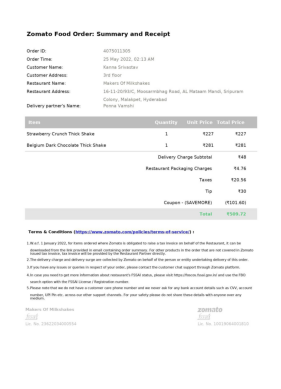

In [20]:
# Select a random image from the test_path directory
random_image_path = select_random_image(test_path)

# Perform the OCR and classification
predicted_class, ocr_text_easyocr, ocr_text_pytesseract = integrate_ocr_with_model(random_image_path)

# Print the results
print(f"Input Image: {random_image_path}")
print(f"Predicted Class: {predicted_class}")
print("OCR Result using EasyOCR:")
for detection in ocr_text_easyocr:
    print(f"Text: {detection[1]}, Confidence: {detection[2]}")

# Display the image
img = Image.open(random_image_path)
plt.imshow(img)
plt.axis('off')
plt.show()

In [21]:
reader = easyocr.Reader(['en'])
result = reader.readtext(random_image_path)

extracted_text = ""
for detection in result:
    extracted_text += detection[1] + " "

print(extracted_text)

Zomato Food Order: Summary and Receipt Order ID: 4075011305 Order Time: 25 May 2022, 02.13 AM Customer Name: Kanna Srivastav Customer Address: 3rd floor Restaurant Name: Makers Of Milkshakes Restaurant Address: 16-11-20/93/C, Moosarmbhag Road, AL Mataam Mandi, Sripuram Colony , Malakpet; Hyderabad Delivery partner's Name: Ponna Vamshi Item Quantity Unit Price Total Price Strawberry Crunch Thick Shake {227 {227 Belgium Dark Chocolate Thick Shake {281 {281 Delivery Charge Subtotal {48 Restaurant Packaging Charges {4.76 Taxes {20.56 {30 Coupon (SAVEMORE) (101.60) Total {509.72 Terms & Conditions (https:llwwwzomato comlpolicieslterms-of-servicel) 1.W.e.f. 1 January 2022 for items ordered where Zomato is obligated to raise a tax invoice on behalf of the Restaurant; it can be downloaded from the link provided in email containing order summary. For other products in the order that are not covered in Zomato issued tax invoice tax invoice be provided by the Restaurant Partner directly: 2.The de

In [22]:
def find_amounts(text):
    amounts = re.findall(r'\d+\.\d{2}\b', text)
    floats = [float(amount) for amount in amounts]
    unique = list(dict.fromkeys(floats))
    return unique

In [23]:
amounts = find_amounts(extracted_text)
amounts

[2.13, 4.76, 20.56, 101.6, 509.72]

In [24]:
print(f"Total: {max(amounts)}")

Total: 509.72


In [30]:
converter = tf.lite.TFLiteConverter.from_keras_model(model)
tflite_model = converter.convert()

In [31]:
with open('model.tflite', 'wb') as f:
    f.write(tflite_model)